# Определение возраста покупателей

&nbsp;&nbsp;&nbsp;Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы и контролировать добросовестность кассиров при продаже алкоголя. Строится модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image



In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


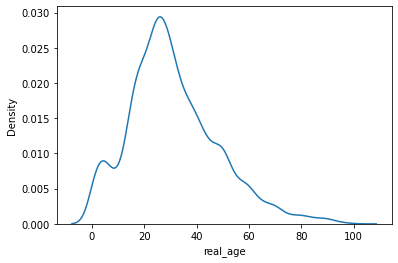

In [4]:
sns.distplot(labels['real_age'], hist = False, kde = True)
plt.show()

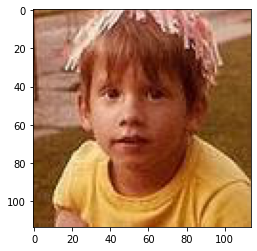

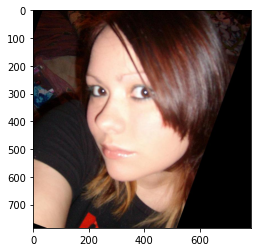

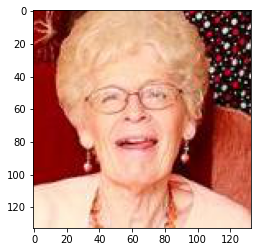

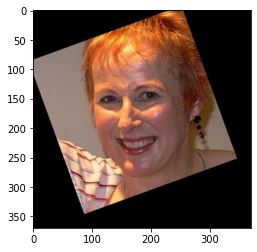

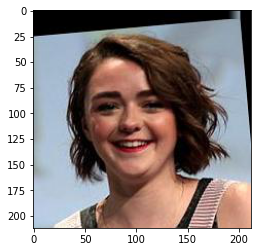

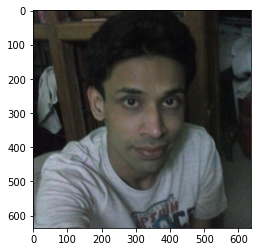

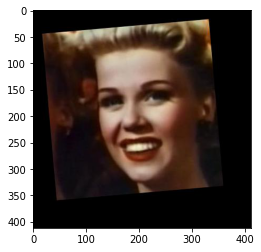

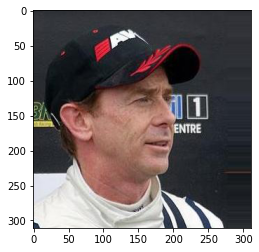

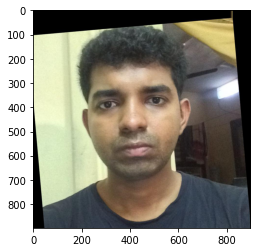

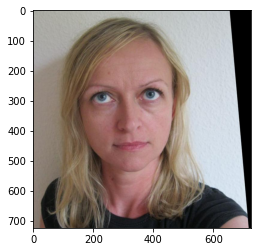

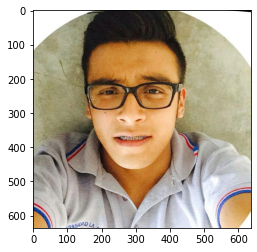

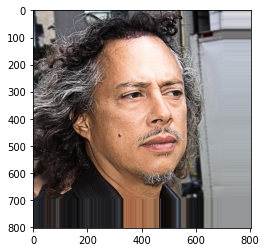

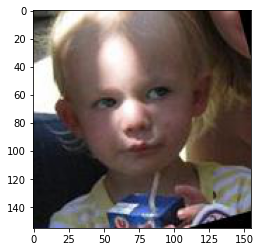

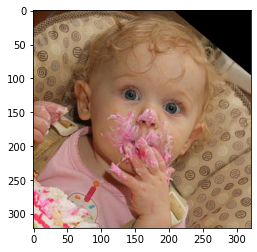

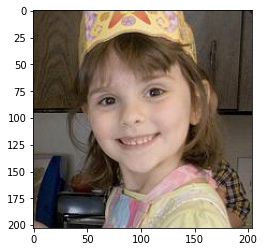

In [5]:
path = '/datasets/faces/final_files/'
for file in labels['file_name'][:15]:
    plt.figure(figsize=(8, 4))
    image = Image.open(path+file)
    plt.imshow(np.array(image)) 

Вывод: у нас явный дизбаланс фотографий людей 60+, однако это и не удивительно. Решение есть - попробовать аугментацию.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import tensorflow as tf


def load_train(path):

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=False, vertical_flip=False)#, rotation_range=90, 
                            #width_shift_range=0.2, height_shift_range=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        
        dataframe=pd.read_csv(path+'labels.csv'),
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
        
        )
    return train_datagen_flow

def create_model(input_shape):



    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)



    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsoluteError(), metrics=['mae'])


    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=50,
               steps_per_epoch=None, validation_steps=None):

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True, callbacks=[early_stopping])


    return model

```

```
2023-08-11 14:02:22.116984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-08-11 14:02:22.118858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-08-11 14:02:23.009832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-08-11 14:02:23.019013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-11 14:02:23.019073: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-11 14:02:23.019104: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-11 14:02:23.021208: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-08-11 14:02:23.021628: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-08-11 14:02:23.023711: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-08-11 14:02:23.024929: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-08-11 14:02:23.024990: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-08-11 14:02:23.027579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-08-11 14:02:23.201296: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-08-11 14:02:23.208833: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-08-11 14:02:23.209435: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3dddcb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-11 14:02:23.209460: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-11 14:02:23.387117: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x343dfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-11 14:02:23.387158: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-08-11 14:02:23.389018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-11 14:02:23.389083: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-11 14:02:23.389097: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-11 14:02:23.389132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-08-11 14:02:23.389148: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-08-11 14:02:23.389161: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-08-11 14:02:23.389174: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-08-11 14:02:23.389185: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-08-11 14:02:23.392294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-08-11 14:02:23.392355: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-11 14:02:23.831255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-08-11 14:02:23.831307: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-08-11 14:02:23.831315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-08-11 14:02:23.833792: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-11 14:02:23.833837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/50
2023-08-11 14:02:38.112351: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-11 14:02:38.847810: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 84s - loss: 12.9275 - mae: 12.9286 - val_loss: 17.4320 - val_mae: 17.4186
Epoch 2/50
178/178 - 56s - loss: 6.9950 - mae: 6.9952 - val_loss: 16.1896 - val_mae: 16.1762
Epoch 3/50
178/178 - 71s - loss: 5.7698 - mae: 5.7702 - val_loss: 11.9120 - val_mae: 11.8827
Epoch 4/50
178/178 - 75s - loss: 4.8404 - mae: 4.8406 - val_loss: 8.4189 - val_mae: 8.3910
Epoch 5/50
178/178 - 73s - loss: 4.4010 - mae: 4.4013 - val_loss: 7.4366 - val_mae: 7.4354
Epoch 6/50
178/178 - 75s - loss: 3.8363 - mae: 3.8366 - val_loss: 6.4401 - val_mae: 6.4571
Epoch 7/50
178/178 - 75s - loss: 3.6615 - mae: 3.6616 - val_loss: 6.3956 - val_mae: 6.4109
Epoch 8/50
178/178 - 75s - loss: 3.3104 - mae: 3.3106 - val_loss: 6.4025 - val_mae: 6.4086
Epoch 9/50
178/178 - 64s - loss: 3.0588 - mae: 3.0589 - val_loss: 6.1918 - val_mae: 6.1968
Epoch 10/50
178/178 - 55s - loss: 2.8377 - mae: 2.8375 - val_loss: 6.4656 - val_mae: 6.4611
Epoch 11/50
178/178 - 54s - loss: 2.7546 - mae: 2.7548 - val_loss: 6.3801 - val_mae: 6.4043
Epoch 12/50
178/178 - 55s - loss: 2.6230 - mae: 2.6232 - val_loss: 6.3266 - val_mae: 6.3292
Epoch 13/50
178/178 - 55s - loss: 2.4842 - mae: 2.4840 - val_loss: 5.9608 - val_mae: 5.9740
Epoch 14/50
178/178 - 54s - loss: 2.3394 - mae: 2.3394 - val_loss: 5.9159 - val_mae: 5.9160
Epoch 15/50
178/178 - 55s - loss: 2.3307 - mae: 2.3310 - val_loss: 6.3904 - val_mae: 6.4109
Epoch 16/50
178/178 - 56s - loss: 2.1628 - mae: 2.1629 - val_loss: 6.0063 - val_mae: 6.0132
Epoch 17/50
178/178 - 62s - loss: 2.1007 - mae: 2.1008 - val_loss: 6.0721 - val_mae: 6.0690
Epoch 18/50
178/178 - 73s - loss: 2.1532 - mae: 2.1531 - val_loss: 6.4081 - val_mae: 6.4066
Epoch 19/50
178/178 - 74s - loss: 2.0912 - mae: 2.0911 - val_loss: 6.1845 - val_mae: 6.1849
Epoch 20/50
178/178 - 75s - loss: 2.0582 - mae: 2.0577 - val_loss: 6.0867 - val_mae: 6.1190
Epoch 21/50
178/178 - 77s - loss: 2.0312 - mae: 2.0312 - val_loss: 5.6980 - val_mae: 5.7357
Epoch 22/50
178/178 - 76s - loss: 1.8841 - mae: 1.8838 - val_loss: 6.0388 - val_mae: 6.0473
Epoch 23/50
178/178 - 75s - loss: 2.0346 - mae: 2.0349 - val_loss: 5.9610 - val_mae: 5.9793
Epoch 24/50
178/178 - 76s - loss: 1.9597 - mae: 1.9598 - val_loss: 6.1129 - val_mae: 6.1272
Epoch 25/50
178/178 - 76s - loss: 1.9097 - mae: 1.9096 - val_loss: 5.7821 - val_mae: 5.7976
Epoch 26/50
178/178 - 75s - loss: 1.7842 - mae: 1.7842 - val_loss: 6.7102 - val_mae: 6.7443
Epoch 27/50
178/178 - 75s - loss: 1.7879 - mae: 1.7880 - val_loss: 6.0897 - val_mae: 6.1199
Epoch 28/50
178/178 - 74s - loss: 1.7249 - mae: 1.7248 - val_loss: 5.7859 - val_mae: 5.7974
Epoch 29/50
178/178 - 54s - loss: 1.6544 - mae: 1.6545 - val_loss: 5.9273 - val_mae: 5.9428
Epoch 30/50
178/178 - 55s - loss: 1.6268 - mae: 1.6267 - val_loss: 5.9620 - val_mae: 5.9855
Epoch 31/50
178/178 - 55s - loss: 1.6254 - mae: 1.6253 - val_loss: 5.8452 - val_mae: 5.8574
Epoch 32/50
178/178 - 55s - loss: 1.6102 - mae: 1.6102 - val_loss: 5.7188 - val_mae: 5.7395
Epoch 33/50
178/178 - 56s - loss: 1.5870 - mae: 1.5870 - val_loss: 5.8621 - val_mae: 5.8828
Epoch 34/50
178/178 - 56s - loss: 1.6493 - mae: 1.6494 - val_loss: 6.0861 - val_mae: 6.0964
Epoch 35/50
178/178 - 56s - loss: 1.5969 - mae: 1.5967 - val_loss: 5.7046 - val_mae: 5.7285
Epoch 36/50
178/178 - 56s - loss: 1.6161 - mae: 1.6161 - val_loss: 5.6756 - val_mae: 5.7012
Epoch 37/50
178/178 - 54s - loss: 1.5320 - mae: 1.5320 - val_loss: 5.7564 - val_mae: 5.7868
Epoch 38/50
178/178 - 55s - loss: 1.6082 - mae: 1.6084 - val_loss: 6.2228 - val_mae: 6.2567
Epoch 39/50
178/178 - 56s - loss: 1.4934 - mae: 1.4934 - val_loss: 5.7810 - val_mae: 5.8019
Epoch 40/50
178/178 - 55s - loss: 1.4601 - mae: 1.4601 - val_loss: 5.8888 - val_mae: 5.8991
Epoch 41/50
178/178 - 75s - loss: 1.4209 - mae: 1.4210 - val_loss: 5.9743 - val_mae: 5.9974
Epoch 42/50
178/178 - 73s - loss: 1.4239 - mae: 1.4240 - val_loss: 6.1667 - val_mae: 6.1961
Epoch 43/50
178/178 - 76s - loss: 1.4856 - mae: 1.4858 - val_loss: 6.3174 - val_mae: 6.3418
Epoch 44/50
178/178 - 77s - loss: 1.4693 - mae: 1.4694 - val_loss: 6.0496 - val_mae: 6.0739
Epoch 45/50
178/178 - 74s - loss: 1.4278 - mae: 1.4277 - val_loss: 5.6798 - val_mae: 5.6858
Epoch 46/50
178/178 - 75s - loss: 1.5367 - mae: 1.5366 - val_loss: 6.1465 - val_mae: 6.1653
Epoch 47/50
178/178 - 76s - loss: 1.4102 - mae: 1.4104 - val_loss: 5.4915 - val_mae: 5.5204
Epoch 48/50
178/178 - 76s - loss: 1.3960 - mae: 1.3957 - val_loss: 5.9177 - val_mae: 5.9376
Epoch 49/50
178/178 - 74s - loss: 1.4121 - mae: 1.4118 - val_loss: 5.7392 - val_mae: 5.7577
Epoch 50/50
178/178 - 75s - loss: 1.3088 - mae: 1.3088 - val_loss: 6.2406 - val_mae: 6.2723
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 6.2406 - mae: 6.2723
Test MAE: 6.2723
```

## Анализ обученной модели

В ходе выполнения работы пробовал использовать аугментацию, однако качество модели было хуже. Так же исследовательский анализ показал, что фотографий 60+ летних людей слишком мало в данных, возможно, именно на этом диапозоне модель ошибается чаще, однако ошибка в 6 лет не столь фатальна для нашей задачи.